<h1> Imports

In [49]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F 
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import time
import re
import string
import nltk
import os
import random

In [50]:
# !pip install torchtext==0.10.0 --user

In [51]:
# !pip install torch==1.11.0 torchtext==0.12.0 --user

In [52]:
import torchtext
from torchtext.data import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import DataLoader
from torchtext.data.functional import to_map_style_dataset

<h1>Import Data

In [53]:
max_words = 25

In [54]:
data = pd.read_csv('datasets/news-article-categories-clean.csv')

<h1> Vocabulary

In [55]:
tokenizer = get_tokenizer("basic_english")

data['tok_body'] = data.body.apply(lambda x: tokenizer(x))

vocab = build_vocab_from_iterator(data['tok_body'], min_freq=1, specials=["<UNK>"])

vocab.set_default_index(vocab["<UNK>"])

len(vocab)

66936

<h1> Tokenization

In [56]:
data["cat"] = pd.Categorical(data.category)
data['cat_code'] = data.cat.cat.codes

In [57]:
data["body_tok"] = data["body"].apply(lambda x: vocab(tokenizer(x)))

In [58]:
data["body_max_len"] = data["body_tok"].apply(lambda x: x+([0]* (max_words-len(x))) if len(x)<max_words else x[:max_words])

In [59]:
data.head()

,category,title,body,tok_body,cat,cat_code,body_tok,body_max_len
0,ARTS & CULTURE,Modeling Agencies Enabled Sexual Predators For...,october carolyn kramer received disturbing pho...,"[october, carolyn, kramer, received, disturbin...",ARTS & CULTURE,0,"[1298, 8062, 5640, 555, 2648, 404, 151, 120, 4...","[1298, 8062, 5640, 555, 2648, 404, 151, 120, 4..."
1,ARTS & CULTURE,Actor Jeff Hiller Talks “Bright Colors And Bol...,week talked actor jeff hiller hit broadway pla...,"[week, talked, actor, jeff, hiller, hit, broad...",ARTS & CULTURE,0,"[58, 1515, 575, 1825, 23777, 531, 1370, 161, 2...","[58, 1515, 575, 1825, 23777, 531, 1370, 161, 2..."
2,ARTS & CULTURE,New Yorker Cover Puts Trump 'In The Hole' Afte...,new yorker taking president donald trump asked...,"[new, yorker, taking, president, donald, trump...",ARTS & CULTURE,0,"[8, 2833, 366, 34, 174, 12, 199, 9, 1646, 613,...","[8, 2833, 366, 34, 174, 12, 199, 9, 1646, 613,..."
3,ARTS & CULTURE,Man Surprises Girlfriend By Drawing Them In Di...,kellen hickey year old life hudson wisconsin g...,"[kellen, hickey, year, old, life, hudson, wisc...",ARTS & CULTURE,0,"[37533, 10231, 3, 90, 24, 8104, 3072, 1278, 84...","[37533, 10231, 3, 90, 24, 8104, 3072, 1278, 84..."
4,ARTS & CULTURE,This Artist Gives Renaissance-Style Sculptures...,something combining traditional uptight look r...,"[something, combining, traditional, uptight, l...",ARTS & CULTURE,0,"[81, 5485, 941, 33242, 95, 6082, 799, 933, 25,...","[81, 5485, 941, 33242, 95, 6082, 799, 933, 25,..."


In [60]:
data = data.drop(range(0, 500), axis = 0)

In [61]:
data.reset_index(drop=True, inplace=True)

In [62]:
data_sans_na = data.dropna()
data_sans_na.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6371 entries, 0 to 6370
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   category      6371 non-null   object  
 1   title         6371 non-null   object  
 2   body          6371 non-null   object  
 3   tok_body      6371 non-null   object  
 4   cat           6371 non-null   category
 5   cat_code      6371 non-null   int8    
 6   body_tok      6371 non-null   object  
 7   body_max_len  6371 non-null   object  
dtypes: category(1), int8(1), object(6)
memory usage: 311.9+ KB


<h1>Target Classes

In [63]:
target_classes = ["ART & CULTURE","BUSINESS","COMEDY","CRIME","EDUCATION","ENTERTAINMENT","ENVIRONMENT","MEDIA","POLITICS","RELIGION","SCIENCE","SPORTS","TECH","WOMEN"]
# target_classes = ["BUSINESS","COMEDY","CRIME","EDUCATION","ENTERTAINMENT","ENVIRONMENT","MEDIA","POLITICS","RELIGION","SCIENCE","SPORTS","TECH","WOMEN"]

In [64]:
len(target_classes)

14

In [65]:
target_classes_int = [i for i in range(14)]

<h1>Train / Test Split

In [66]:
X = data_sans_na.drop(["category", "cat_code", "cat"], axis =1)
y = data_sans_na["cat_code"]

In [67]:
X.head()

,title,body,tok_body,body_tok,body_max_len
0,"John Williams Has Never Seen 'Star Wars,' Does...",musical composition simply destined live forev...,"[musical, composition, simply, destined, live,...","[958, 3831, 511, 11952, 195, 2014, 724, 408, 6...","[958, 3831, 511, 11952, 195, 2014, 724, 408, 6..."
1,"An Alert, Well-Hydrated Artist in No Acute Dis...",serial two artist incurable neurological disea...,"[serial, two, artist, incurable, neurological,...","[3155, 28, 106, 26752, 10908, 1361, 1230, 481,...","[3155, 28, 106, 26752, 10908, 1361, 1230, 481,..."
2,Stage Door: Ute Lemper's Songs From The Broken...,ute lemper acclaimed german chanteuse bares co...,"[ute, lemper, acclaimed, german, chanteuse, ba...","[41585, 24026, 4984, 2130, 34756, 43671, 10456...","[41585, 24026, 4984, 2130, 34756, 43671, 10456..."
3,Donna Quesada: Art Review,dear friend larry payne mentioned purchased th...,"[dear, friend, larry, payne, mentioned, purcha...","[2410, 133, 1409, 8487, 2248, 3461, 101, 7306,...","[2410, 133, 1409, 8487, 2248, 3461, 101, 7306,..."
4,Top 5 Sizzling Hot Winter Music Festivals in F...,andrew cyrille photo petra cvelbar thelonious ...,"[andrew, cyrille, photo, petra, cvelbar, thelo...","[2040, 35217, 170, 9271, 46730, 13211, 5778, 1...","[2040, 35217, 170, 9271, 46730, 13211, 5778, 1..."


In [68]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: cat_code, dtype: int8

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

In [70]:
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

<h1> Vectorize Batch

In [71]:
def vectorize_batch(batch):
    Y = tuple(map(lambda x: x["label"], batch))
    X = tuple(map(lambda x: x["text"], batch))
    X_t = torch.tensor(X,dtype=torch.long)
    Y_t = torch.tensor(Y, dtype=torch.long)
    return X_t, Y_t 
   

<h1> Load Data

In [72]:
# Définir une classe pour transformer un Dataframe en Dataset
class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        row = self.data.iloc[index]
        text = row['body_max_len']
        label = row['cat_code']
        return {'label': label, 'text': text}

# Créer une instance de la classe Dataset personnalisée
train_dataset = CustomDataset(train)
test_dataset = CustomDataset(test)

train_dataset, test_dataset  = to_map_style_dataset(train_dataset), to_map_style_dataset(test_dataset)

In [73]:
train_loader = DataLoader(train_dataset, batch_size=1024, collate_fn= vectorize_batch, shuffle=True)
test_loader  = DataLoader(test_dataset , batch_size=1024, collate_fn=vectorize_batch)

In [74]:
for X, Y in train_loader:
    print(X.shape, Y.shape)
    break

torch.Size([1024, 25]) torch.Size([1024])


<h1> RNN

In [75]:
#Paramètres du modèle
EMBED_LEN = 200
HIDDEN_SIZE1 = 200
HIDDEN_SIZE2 = 100
HIDDEN_SIZE3 = 150
OUTPUT_SIZE = len(target_classes)
N_LAYERS = 5

In [76]:
#Classe pour le modèle RNN simple
class RNNClassifier1(nn.Module):
    def __init__(self):
        super(RNNClassifier1, self).__init__()
        self.embedding_layer = nn.Embedding(num_embeddings=len(vocab), embedding_dim=EMBED_LEN)
        self.rnn = nn.RNN(input_size=EMBED_LEN, hidden_size=HIDDEN_SIZE1, num_layers=N_LAYERS, batch_first=True)
        self.linear = nn.Linear(HIDDEN_SIZE1, OUTPUT_SIZE)

    def forward(self, X_batch):
        embeddings = self.embedding_layer(X_batch)
        output, hidden = self.rnn(embeddings, torch.randn(N_LAYERS, len(X_batch), HIDDEN_SIZE1))
        return self.linear(output[:,-1])

In [77]:
#Classe pour le modèle a multiple RNN 
class RNNClassifier2(nn.Module):
    def __init__(self):
        super(RNNClassifier2, self).__init__()
        self.embedding_layer = nn.Embedding(num_embeddings=len(vocab), embedding_dim=EMBED_LEN)
        self.rnn1 = nn.RNN(input_size=EMBED_LEN, hidden_size=HIDDEN_SIZE1, num_layers=N_LAYERS, batch_first=True)
        self.rnn2 = nn.RNN(input_size=HIDDEN_SIZE1, hidden_size=HIDDEN_SIZE2, num_layers=N_LAYERS, batch_first=True)
        self.rnn3 = nn.RNN(input_size=HIDDEN_SIZE2, hidden_size=HIDDEN_SIZE3, num_layers=N_LAYERS, batch_first=True)
        self.linear = nn.Linear(HIDDEN_SIZE3, OUTPUT_SIZE)

    def forward(self, X_batch):
        embeddings = self.embedding_layer(X_batch)
        output, hidden = self.rnn1(embeddings, torch.randn(N_LAYERS, len(X_batch), HIDDEN_SIZE1))
        output, hidden = self.rnn2(output, torch.randn(N_LAYERS, len(X_batch), HIDDEN_SIZE2))
        output, hidden = self.rnn3(output, torch.randn(N_LAYERS, len(X_batch), HIDDEN_SIZE3))
        return self.linear(output[:,-1])

In [78]:
rnn_classifier1 = RNNClassifier1()

rnn_classifier1

RNNClassifier1(
  (embedding_layer): Embedding(66936, 200)
  (rnn): RNN(200, 200, num_layers=5, batch_first=True)
  (linear): Linear(in_features=200, out_features=14, bias=True)
)

In [79]:
rnn_classifier2 = RNNClassifier2()

rnn_classifier2

RNNClassifier2(
  (embedding_layer): Embedding(66936, 200)
  (rnn1): RNN(200, 200, num_layers=5, batch_first=True)
  (rnn2): RNN(200, 100, num_layers=5, batch_first=True)
  (rnn3): RNN(100, 150, num_layers=5, batch_first=True)
  (linear): Linear(in_features=150, out_features=14, bias=True)
)

In [80]:
for layer in rnn_classifier1.children():
    print("Layer : {}".format(layer))
    print("Parameters : ")
    for param in layer.parameters():
        print(param.shape)
    print()

Layer : Embedding(66936, 200)
Parameters : 
torch.Size([66936, 200])

Layer : RNN(200, 200, num_layers=5, batch_first=True)
Parameters : 
torch.Size([200, 200])
torch.Size([200, 200])
torch.Size([200])
torch.Size([200])
torch.Size([200, 200])
torch.Size([200, 200])
torch.Size([200])
torch.Size([200])
torch.Size([200, 200])
torch.Size([200, 200])
torch.Size([200])
torch.Size([200])
torch.Size([200, 200])
torch.Size([200, 200])
torch.Size([200])
torch.Size([200])
torch.Size([200, 200])
torch.Size([200, 200])
torch.Size([200])
torch.Size([200])

Layer : Linear(in_features=200, out_features=14, bias=True)
Parameters : 
torch.Size([14, 200])
torch.Size([14])



In [81]:
out = rnn_classifier1(torch.randint(0, len(vocab), (1024, max_words)))

out.shape

torch.Size([1024, 14])

In [82]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import gc

def calc_val_loss_and_accuracy(model, loss_fn, val_loader):
    with torch.no_grad():
        Y_shuffled, Y_preds, losses = [],[],[]
        for X, Y in val_loader:
            preds = model(X)
            loss = loss_fn(preds, Y)
            losses.append(loss.item())

            Y_shuffled.append(Y)
            Y_preds.append(preds.argmax(dim=-1))

        Y_shuffled = torch.cat(Y_shuffled)
        Y_preds = torch.cat(Y_preds)

        print("Valid Loss : {:.3f}".format(torch.tensor(losses).mean()))
        print("Valid Acc  : {:.3f}".format(accuracy_score(Y_shuffled.detach().numpy(), Y_preds.detach().numpy())))


def train_model(model, loss_fn, optimizer, train_loader, val_loader, epochs=10):
    for i in range(1, epochs+1):
        losses = []
        for X, Y in tqdm(train_loader):
            Y_preds = model(X)

            loss = loss_fn(Y_preds, Y)
            losses.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print("Train Loss : {:.3f}".format(torch.tensor(losses).mean()))
        calc_val_loss_and_accuracy(model, loss_fn, val_loader)

<h1> Entrainement Single RNN

In [83]:
from torch.optim import Adam

epochs = 15
learning_rate = 1e-3

loss_fn = nn.CrossEntropyLoss()
rnn_classifier = RNNClassifier1()
optimizer = Adam(rnn_classifier.parameters(), lr=learning_rate)

In [84]:
train_model(rnn_classifier, loss_fn, optimizer, train_loader, test_loader, epochs)

100%|██████████| 5/5 [00:03<00:00,  1.37it/s]


Train Loss : 2.626
Valid Loss : 2.616
Valid Acc  : 0.098


100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


Train Loss : 2.512
Valid Loss : 2.572
Valid Acc  : 0.122


100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


Train Loss : 2.363
Valid Loss : 2.570
Valid Acc  : 0.143


100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


Train Loss : 2.188
Valid Loss : 2.542
Valid Acc  : 0.173


100%|██████████| 5/5 [00:03<00:00,  1.46it/s]


Train Loss : 1.999
Valid Loss : 2.538
Valid Acc  : 0.178


100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


Train Loss : 1.808
Valid Loss : 2.558
Valid Acc  : 0.196


100%|██████████| 5/5 [00:03<00:00,  1.45it/s]


Train Loss : 1.617
Valid Loss : 2.562
Valid Acc  : 0.207


100%|██████████| 5/5 [00:03<00:00,  1.45it/s]


Train Loss : 1.440
Valid Loss : 2.558
Valid Acc  : 0.221


100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


Train Loss : 1.249
Valid Loss : 2.679
Valid Acc  : 0.197


100%|██████████| 5/5 [00:03<00:00,  1.46it/s]


Train Loss : 1.056
Valid Loss : 2.672
Valid Acc  : 0.228


100%|██████████| 5/5 [00:03<00:00,  1.45it/s]


Train Loss : 0.871
Valid Loss : 2.803
Valid Acc  : 0.218


100%|██████████| 5/5 [00:03<00:00,  1.46it/s]


Train Loss : 0.694
Valid Loss : 2.816
Valid Acc  : 0.238


100%|██████████| 5/5 [00:03<00:00,  1.51it/s]


Train Loss : 0.542
Valid Loss : 3.028
Valid Acc  : 0.223


100%|██████████| 5/5 [00:03<00:00,  1.46it/s]


Train Loss : 0.403
Valid Loss : 3.050
Valid Acc  : 0.251


100%|██████████| 5/5 [00:03<00:00,  1.47it/s]


Train Loss : 0.295
Valid Loss : 3.238
Valid Acc  : 0.245


In [85]:
def MakePredictions(model, loader):
    Y_shuffled, Y_preds = [], []
    for X, Y in loader:
        preds = model(X)
        Y_preds.append(preds)
        Y_shuffled.append(Y)
    gc.collect()
    Y_preds, Y_shuffled = torch.cat(Y_preds), torch.cat(Y_shuffled)

    return Y_shuffled.detach().numpy(), F.softmax(Y_preds, dim=-1).argmax(dim=-1).detach().numpy()

Y_actual, Y_preds = MakePredictions(rnn_classifier, test_loader)

In [86]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("Test Accuracy : {}".format(accuracy_score(Y_actual, Y_preds)))
print("\nClassification Report : ")
print(classification_report(Y_actual, Y_preds, target_names=target_classes))
print("\nConfusion Matrix : ")
print(confusion_matrix(Y_actual, Y_preds))

Test Accuracy : 0.24705882352941178

Classification Report : 
               precision    recall  f1-score   support

ART & CULTURE       0.22      0.14      0.17       105
     BUSINESS       0.12      0.14      0.13        90
       COMEDY       0.26      0.39      0.31        62
        CRIME       0.16      0.25      0.20        52
    EDUCATION       0.38      0.29      0.33       106
ENTERTAINMENT       0.20      0.21      0.20        96
  ENVIRONMENT       0.23      0.27      0.25        96
        MEDIA       0.25      0.19      0.22        67
     POLITICS       0.34      0.35      0.34       111
     RELIGION       0.12      0.12      0.12        94
      SCIENCE       0.25      0.21      0.23        87
       SPORTS       0.43      0.39      0.41       117
         TECH       0.16      0.18      0.17        88
        WOMEN       0.35      0.29      0.32       104

     accuracy                           0.25      1275
    macro avg       0.25      0.24      0.24      1275
 

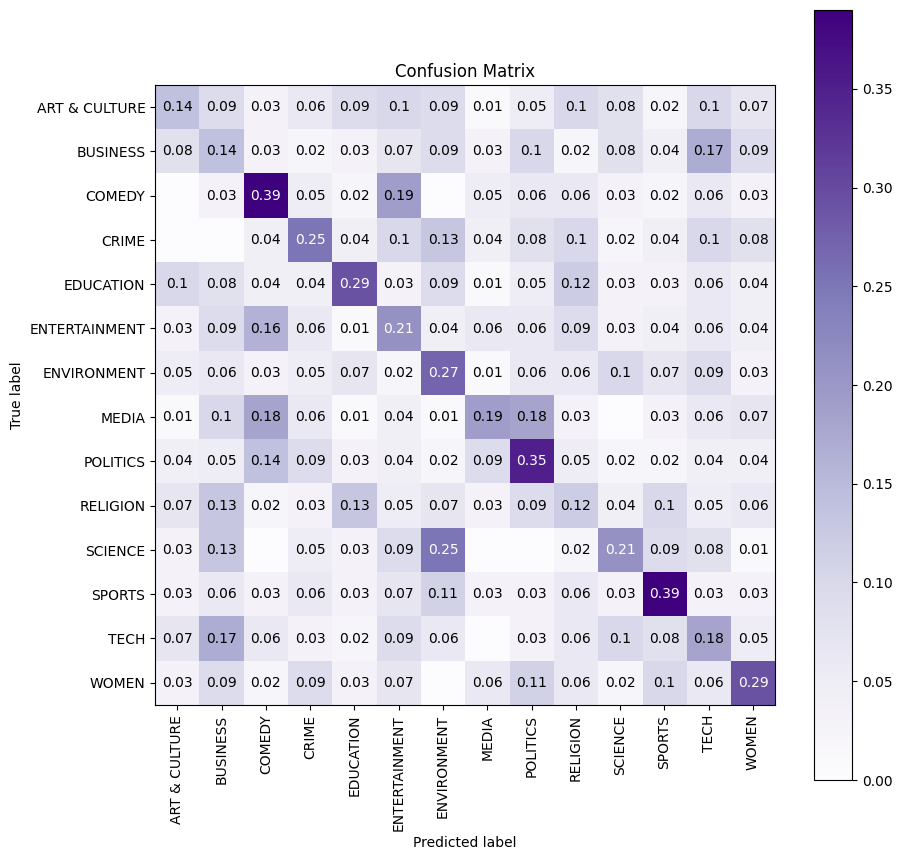

In [87]:
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
import matplotlib.pyplot as plt
import numpy as np

skplt.metrics.plot_confusion_matrix([target_classes[i] for i in Y_actual], [target_classes[i] for i in Y_preds],
                                    normalize=True,
                                    title="Confusion Matrix",
                                    cmap="Purples",
                                    hide_zeros=True,
                                    figsize=(10,10)
                                    );
plt.xticks(rotation=90);

<h1> Entrainement Multi RNN

In [88]:
epochs = 15
learning_rate = 1e-3

loss_fn = nn.CrossEntropyLoss()
rnn_classifier = RNNClassifier2()
optimizer = Adam(rnn_classifier.parameters(), lr=learning_rate)

In [89]:
train_model(rnn_classifier, loss_fn, optimizer, train_loader, test_loader, epochs)

100%|██████████| 5/5 [00:06<00:00,  1.35s/it]


Train Loss : 2.635
Valid Loss : 2.634
Valid Acc  : 0.089


100%|██████████| 5/5 [00:06<00:00,  1.30s/it]


Train Loss : 2.612
Valid Loss : 2.626
Valid Acc  : 0.099


100%|██████████| 5/5 [00:06<00:00,  1.36s/it]


Train Loss : 2.573
Valid Loss : 2.587
Valid Acc  : 0.102


100%|██████████| 5/5 [00:06<00:00,  1.30s/it]


Train Loss : 2.531
Valid Loss : 2.544
Valid Acc  : 0.118


100%|██████████| 5/5 [00:06<00:00,  1.28s/it]


Train Loss : 2.466
Valid Loss : 2.555
Valid Acc  : 0.124


100%|██████████| 5/5 [00:06<00:00,  1.29s/it]


Train Loss : 2.404
Valid Loss : 2.601
Valid Acc  : 0.102


100%|██████████| 5/5 [00:06<00:00,  1.34s/it]


Train Loss : 2.336
Valid Loss : 2.628
Valid Acc  : 0.115


100%|██████████| 5/5 [00:06<00:00,  1.38s/it]


Train Loss : 2.252
Valid Loss : 2.633
Valid Acc  : 0.134


100%|██████████| 5/5 [00:06<00:00,  1.35s/it]


Train Loss : 2.168
Valid Loss : 2.692
Valid Acc  : 0.111


100%|██████████| 5/5 [00:06<00:00,  1.37s/it]


Train Loss : 2.079
Valid Loss : 2.743
Valid Acc  : 0.118


100%|██████████| 5/5 [00:06<00:00,  1.33s/it]


Train Loss : 1.986
Valid Loss : 2.824
Valid Acc  : 0.127


100%|██████████| 5/5 [00:06<00:00,  1.34s/it]


Train Loss : 1.892
Valid Loss : 2.904
Valid Acc  : 0.115


100%|██████████| 5/5 [00:06<00:00,  1.31s/it]


Train Loss : 1.800
Valid Loss : 2.994
Valid Acc  : 0.124


100%|██████████| 5/5 [00:06<00:00,  1.38s/it]


Train Loss : 1.726
Valid Loss : 3.008
Valid Acc  : 0.133


100%|██████████| 5/5 [00:06<00:00,  1.36s/it]


Train Loss : 1.605
Valid Loss : 3.049
Valid Acc  : 0.139


In [90]:
print("Test Accuracy : {}".format(accuracy_score(Y_actual, Y_preds)))
print("\nClassification Report : ")
print(classification_report(Y_actual, Y_preds, target_names=target_classes))
print("\nConfusion Matrix : ")
print(confusion_matrix(Y_actual, Y_preds))

Test Accuracy : 0.24705882352941178

Classification Report : 
               precision    recall  f1-score   support

ART & CULTURE       0.22      0.14      0.17       105
     BUSINESS       0.12      0.14      0.13        90
       COMEDY       0.26      0.39      0.31        62
        CRIME       0.16      0.25      0.20        52
    EDUCATION       0.38      0.29      0.33       106
ENTERTAINMENT       0.20      0.21      0.20        96
  ENVIRONMENT       0.23      0.27      0.25        96
        MEDIA       0.25      0.19      0.22        67
     POLITICS       0.34      0.35      0.34       111
     RELIGION       0.12      0.12      0.12        94
      SCIENCE       0.25      0.21      0.23        87
       SPORTS       0.43      0.39      0.41       117
         TECH       0.16      0.18      0.17        88
        WOMEN       0.35      0.29      0.32       104

     accuracy                           0.25      1275
    macro avg       0.25      0.24      0.24      1275
 

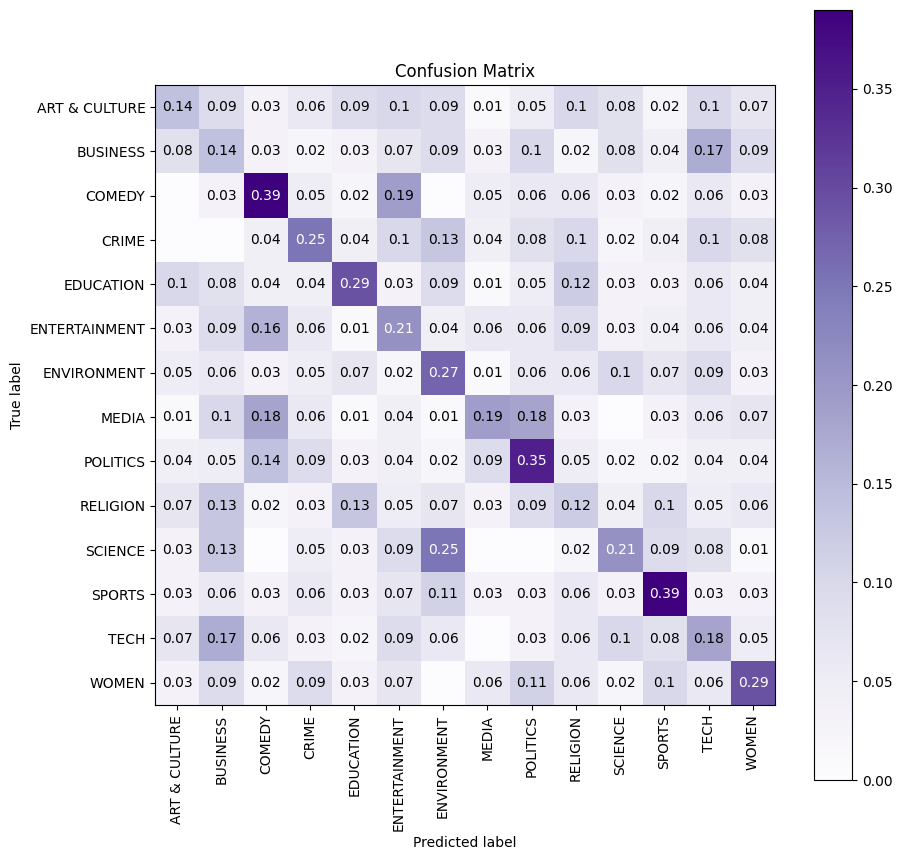

In [91]:
skplt.metrics.plot_confusion_matrix([target_classes[i] for i in Y_actual], [target_classes[i] for i in Y_preds],
                                    normalize=True,
                                    title="Confusion Matrix",
                                    cmap="Purples",
                                    hide_zeros=True,
                                    figsize=(10,10)
                                    );
plt.xticks(rotation=90);